# Import Libraries

In [99]:
import numpy as np
import pandas as pd
import keras
from keras import layers
from keras.datasets import mnist
from keras import regularizers
from keras import backend as K
import matplotlib.pyplot as plt
import statistics
from scipy.stats import norm

# Loading Dataset, Editing Data

In [100]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [101]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


# Basic AutoEncoder

In [102]:
input = keras.Input(shape=(784,))

layer1 = layers.Dense(128, activation='relu')(input)
layer2 = layers.Dense(64, activation='relu')(layer1)
encoded = layers.Dense(32, activation='relu')(layer2)
layer3 = layers.Dense(64, activation='relu')(encoded)
layer4 = layers.Dense(128, activation='relu')(layer3)

decoded = layers.Dense(784, activation='sigmoid')(layer4)

In [103]:
# we don't have a y, and it is x_train, x_test here 
# Accuracy metric doesn't work v well

autoencoder = keras.Model(input, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train, epochs=25, batch_size=256, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/25
235/235 [==============================] - 2s 7ms/step - loss: 0.2408 - val_loss: 0.1633
Epoch 2/25
235/235 [==============================] - 1s 6ms/step - loss: 0.1468 - val_loss: 0.1341
Epoch 3/25
235/235 [==============================] - 1s 6ms/step - loss: 0.1289 - val_loss: 0.1217
Epoch 4/25
235/235 [==============================] - 1s 6ms/step - loss: 0.1195 - val_loss: 0.1153
Epoch 5/25
235/235 [==============================] - 1s 6ms/step - loss: 0.1141 - val_loss: 0.1105
Epoch 6/25
235/235 [==============================] - 1s 6ms/step - loss: 0.1099 - val_loss: 0.1068
Epoch 7/25
235/235 [==============================] - 1s 6ms/step - loss: 0.1066 - val_loss: 0.1042
Epoch 8/25
235/235 [==============================] - 1s 6ms/step - loss: 0.1040 - val_loss: 0.1015
Epoch 9/25
235/235 [==============================] - 1s 6ms/step - loss: 0.1018 - val_loss: 0.1000
Epoch 10/25
235/235 [==============================] - 1s 6ms/step - loss: 0.1001 - val_loss: 0.0984

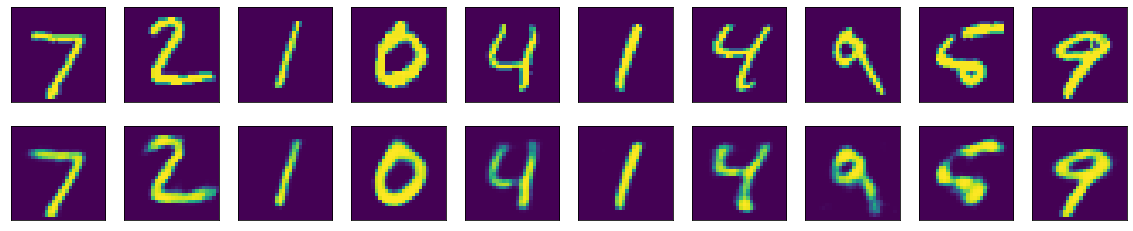

In [104]:
decoded_imgs = autoencoder.predict(x_test)

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Variational AutoEncoder

In [105]:
inputs = keras.Input(shape=(784,))

layer1 = layers.Dense(64, activation='relu')(inputs)

z_mean = layers.Dense(2)(layer1)
z_sigma = layers.Dense(2)(layer1)

In [106]:
def sampling(args):
    z_mean, z_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], 2), mean=0.0, stddev=0.1)
    return z_mean + K.exp(z_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_sigma])

In [107]:
encoder = keras.Model(inputs, [z_mean, z_sigma, z], name='encoder')

latent_inputs = keras.Input(shape=(2,), name='z_sampling')
x = layers.Dense(64, activation='relu')(latent_inputs)
outputs = layers.Dense(784, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

outputs = decoder(encoder(inputs)[2])


In [108]:
# we don't have a y, and it is x_train, x_test here 
# Accuracy metric doesn't work v well

vae = keras.Model(inputs, outputs, name='vae_mlp')

reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= 784
kl_loss = 1 + z_sigma - K.square(z_mean) - K.exp(z_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

vae.compile(optimizer='adam')
vae.fit(x_train, x_train, epochs=25, batch_size=32, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/25
1875/1875 [==============================] - 9s 4ms/step - loss: 187.2232 - val_loss: 169.6398
Epoch 2/25
1875/1875 [==============================] - 8s 4ms/step - loss: 166.6770 - val_loss: 164.0178
Epoch 3/25
1875/1875 [==============================] - 8s 4ms/step - loss: 162.7074 - val_loss: 161.3984
Epoch 4/25
1875/1875 [==============================] - 8s 4ms/step - loss: 160.3121 - val_loss: 159.5817
Epoch 5/25
1875/1875 [==============================] - 9s 5ms/step - loss: 158.6041 - val_loss: 158.0541
Epoch 6/25
1875/1875 [==============================] - 8s 4ms/step - loss: 157.1721 - val_loss: 156.8503
Epoch 7/25
1875/1875 [==============================] - 8s 4ms/step - loss: 155.9180 - val_loss: 155.6194
Epoch 8/25
1875/1875 [==============================] - 8s 4ms/step - loss: 154.8337 - val_loss: 154.5554
Epoch 9/25
1875/1875 [==============================] - 8s 4ms/step - loss: 153.9544 - val_loss: 153.9762
Epoch 10/25
1875/1875 [=======================

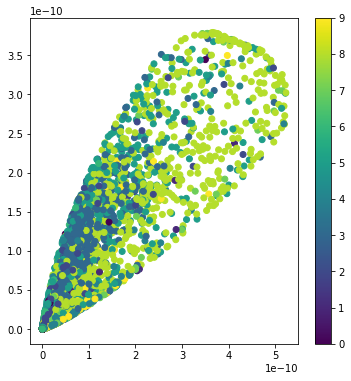

In [109]:
x_test_encoded = vae.predict(x_test)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

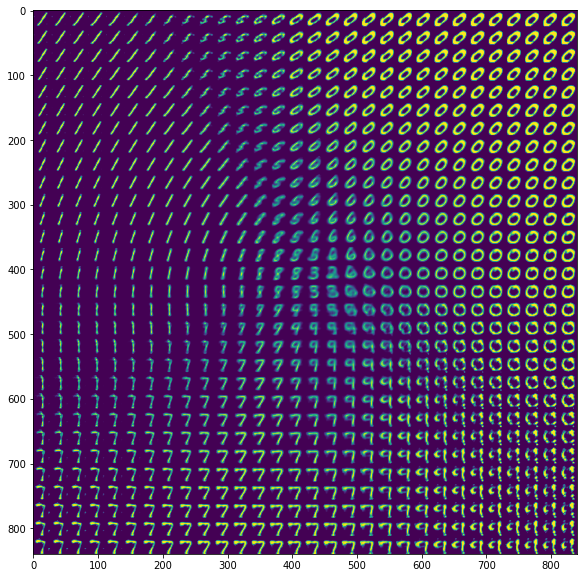

In [110]:
# Q1.2

n = 30 
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-5, 5, n)
grid_y = np.linspace(-5, 5, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

# This plot shows what the model associates with each part of the latent space.
# https://jaan.io/what-is-variational-autoencoder-vae-tutorial/

In [138]:
z_mean1, z_sigma1, z_dist = encoder.predict(x_train)
df1 = pd.DataFrame({'mean': z_dist[:, 0], 'stdev': z_dist[:, 1], 'digit': y_train})

In [136]:
def digit_plot(digit):
    df2 = df1[df1['digit'] == digit][['mean', 'stdev']].head(1)
    x_axis = np.arange(-10, 10, 0.1)
    plt.plot(x_axis, norm.pdf(x_axis, df2['mean'], np.exp(df2['stdev'])))
    plt.title(("Plot for digit", digit))
    plt.show()

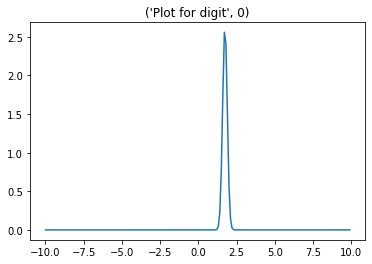

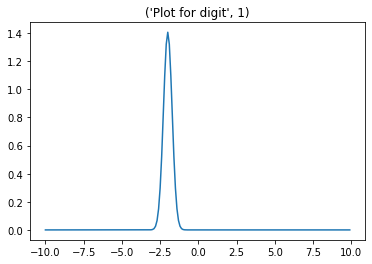

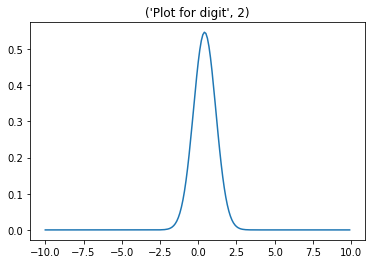

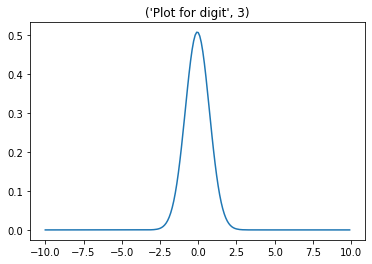

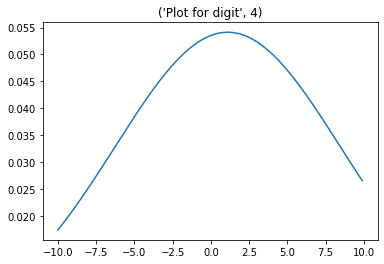

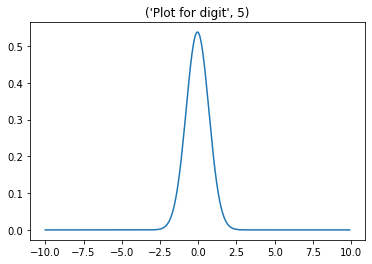

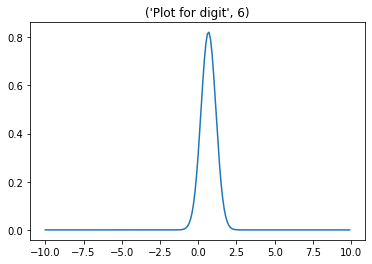

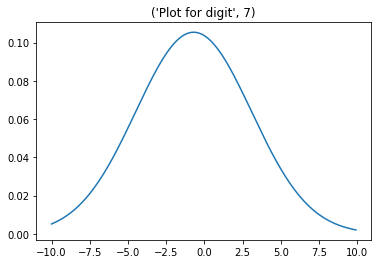

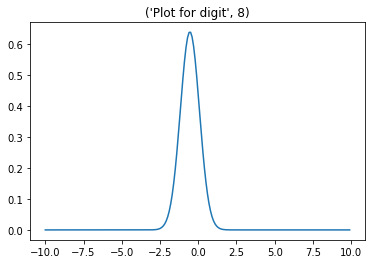

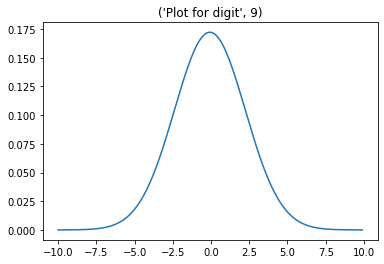

In [137]:
# Q1.1

for i in range(10):
    digit_plot(i)